# Winner's Curse Correction in Python

This notebook demonstrates how to correct for winner's curse bias in GWAS effect size estimates.

Winner's curse refers to the systematic overestimation of genetic effects when variants are selected based on significance thresholds. This correction uses the conditional likelihood approach to obtain unbiased effect size estimates.

In [15]:
## Import required libraries

In [16]:
import scipy.stats as sp
import scipy.optimize
import numpy as np

## Winner's Curse Correction Function

The correction function solves for the true effect size $\beta_{True}$ that satisfies:

$$E(\beta_{Observed}; \beta_{True}) = \beta_{Observed}$$

where the expected value is given by:

$$E(\beta_{Observed}; \beta_{True}) = \beta_{True} + \sigma \frac{\phi(\frac{\beta_{True}}{\sigma}-c) - \phi(\frac{-\beta_{True}}{\sigma}-c)}{\Phi(\frac{\beta_{True}}{\sigma}-c) + \Phi(\frac{-\beta_{True}}{\sigma}-c)}$$

This is solved numerically using Brent's method to find the root of the bias function.

In [17]:
def wc_correct(beta, se, sig_level=5e-8):
    """
    Correct for winner's curse bias in effect size estimates.
    
    Parameters:
    -----------
    beta : float or array-like
        Observed effect size(s)
    se : float or array-like
        Standard error(s) of the effect size(s)
    sig_level : float
        Significance threshold (default: 5e-8 for genome-wide significance)
        
    Returns:
    --------
    float or array
        Corrected effect size(s)
    """
    # Calculate z-score cutpoint
    c2 = sp.chi2.ppf(1 - sig_level, df=1)
    c = np.sqrt(c2)
    
    def bias(beta_T, beta_O, se):
        """Calculate the bias for a given true effect size."""
        z = beta_T / se
        numerator = sp.norm.pdf(z - c) - sp.norm.pdf(-z - c)
        denominator = sp.norm.cdf(z - c) + sp.norm.cdf(-z - c)
        return beta_T + se * numerator / denominator - beta_O
    
    # Convert to numpy arrays for easier handling
    beta = np.asarray(beta)
    se = np.asarray(se)
    
    # Handle broadcasting: if one is scalar and the other is array
    if beta.ndim == 0 and se.ndim > 0:
        # beta is scalar, se is array - broadcast beta
        beta = np.broadcast_to(beta, se.shape)
    elif beta.ndim > 0 and se.ndim == 0:
        # beta is array, se is scalar - broadcast se
        se = np.broadcast_to(se, beta.shape)
    elif beta.ndim > 0 and se.ndim > 0:
        # Both are arrays - ensure they have compatible shapes
        if beta.shape != se.shape:
            raise ValueError(f"beta and se must have compatible shapes. Got {beta.shape} and {se.shape}")
    
    # Handle both scalar and array inputs
    if beta.ndim == 0:  # Both are scalars
        beta_corrected = scipy.optimize.brentq(
            lambda x: bias(x, beta.item(), se.item()),
            a=-100, b=100,
            maxiter=1000
        )
    else:  # At least one is an array
        beta_corrected = np.array([
            scipy.optimize.brentq(
                lambda x: bias(x, b, s),
                a=-100, b=100,
                maxiter=1000
            )
            for b, s in zip(np.atleast_1d(beta).flat, np.atleast_1d(se).flat)
        ])
        # Reshape to match input shape
        if beta.ndim > 0:
            beta_corrected = beta_corrected.reshape(beta.shape)
    
    return beta_corrected

## Example 1: Single variant correction

Let's correct a single variant with an observed effect size of 0.15 and standard error of 0.02.

In [18]:
# Example 1: Single variant
beta_obs = 0.15
se = 0.02
beta_corrected = wc_correct(beta_obs, se)

print(f"Observed effect: {beta_obs:.4f}")
print(f"Corrected effect: {beta_corrected:.4f}")
print(f"Bias: {beta_obs - beta_corrected:.4f}")
print(f"Bias percentage: {(beta_obs - beta_corrected) / beta_obs * 100:.2f}%")

Observed effect: 0.1500
Corrected effect: 0.1489
Bias: 0.0011
Bias percentage: 0.75%


## Example 2: Multiple variants

We can also correct multiple variants at once by passing arrays.

In [19]:
# Example 2: Multiple variants
beta_obs_array = np.array([0.15, 0.20, 0.10, 0.25])
se_array = np.array([0.02, 0.025, 0.015, 0.03])

beta_corrected_array = wc_correct(beta_obs_array, se_array)

print("Variant | Observed | Corrected | Bias")
print("-" * 45)
for i, (obs, corr) in enumerate(zip(beta_obs_array, beta_corrected_array)):
    bias = obs - corr
    print(f"   {i+1}   |  {obs:.4f}  |  {corr:.4f}  | {bias:.4f}")

Variant | Observed | Corrected | Bias
---------------------------------------------
   1   |  0.1500  |  0.1489  | 0.0011
   2   |  0.2000  |  0.1996  | 0.0004
   3   |  0.1000  |  0.0950  | 0.0050
   4   |  0.2500  |  0.2498  | 0.0002


## Example 3: Visualizing the correction

Let's visualize how the correction affects effect sizes for different observed values.

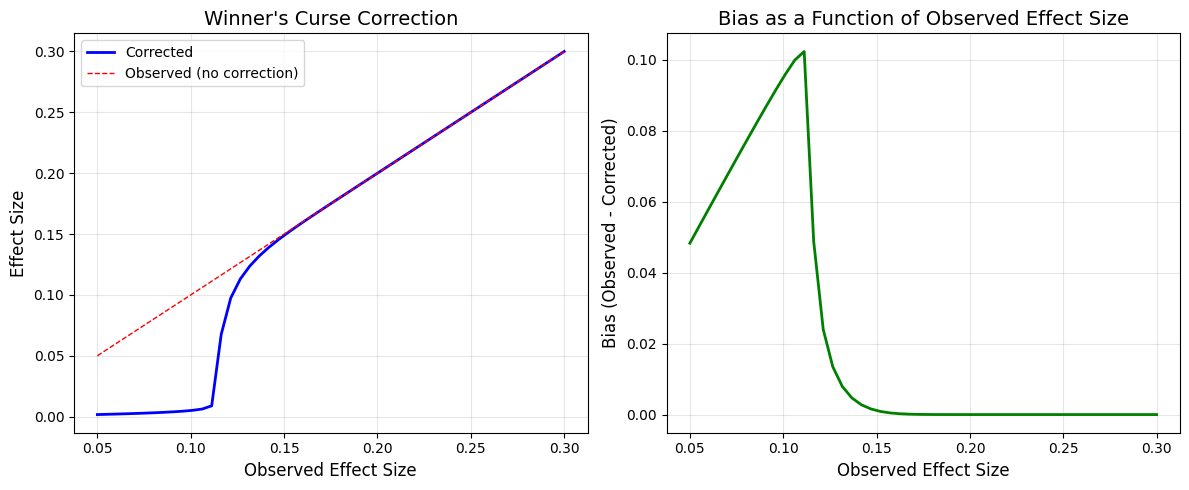

In [20]:
import matplotlib.pyplot as plt

# Generate a range of observed effect sizes
beta_obs_range = np.linspace(0.05, 0.3, 50)
se_fixed = 0.02

# Correct all values
beta_corrected_range = wc_correct(beta_obs_range, se_fixed)

# Calculate bias
bias_range = beta_obs_range - beta_corrected_range

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Observed vs Corrected
ax1.plot(beta_obs_range, beta_corrected_range, 'b-', linewidth=2, label='Corrected')
ax1.plot(beta_obs_range, beta_obs_range, 'r--', linewidth=1, label='Observed (no correction)')
ax1.set_xlabel('Observed Effect Size', fontsize=12)
ax1.set_ylabel('Effect Size', fontsize=12)
ax1.set_title('Winner\'s Curse Correction', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bias
ax2.plot(beta_obs_range, bias_range, 'g-', linewidth=2)
ax2.set_xlabel('Observed Effect Size', fontsize=12)
ax2.set_ylabel('Bias (Observed - Corrected)', fontsize=12)
ax2.set_title('Bias as a Function of Observed Effect Size', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Example 4: Effect of standard error on bias

The bias is larger when the standard error is larger relative to the true effect size. Let's demonstrate this.

In [21]:
# Compare bias for different standard errors
beta_obs = 0.15
se_values = [0.01, 0.02, 0.03, 0.04, 0.05]

print(f"Observed effect: {beta_obs:.4f}")
print("\nSE      | Corrected | Bias    | Bias %")
print("-" * 40)
for se in se_values:
    beta_corr = wc_correct(beta_obs, se)
    bias = beta_obs - beta_corr
    bias_pct = bias / beta_obs * 100
    print(f"{se:.4f}  |  {beta_corr:.4f}  | {bias:.4f} | {bias_pct:.2f}%")

Observed effect: 0.1500

SE      | Corrected | Bias    | Bias %
----------------------------------------
0.0100  |  0.1500  | -0.0000 | -0.00%
0.0200  |  0.1489  | 0.0011 | 0.75%
0.0300  |  0.0075  | 0.1425 | 94.98%
0.0400  |  0.0057  | 0.1443 | 96.19%
0.0500  |  0.0053  | 0.1447 | 96.48%


## Example 5: Applying to GWAS summary statistics

Here's how you would apply the correction to real GWAS summary statistics.

In [22]:
# Example: Simulated GWAS summary statistics
# In practice, you would load this from a file:
# import pandas as pd
# sumstats = pd.read_csv("gwas_results.tsv", sep="\t")

# Simulated data for demonstration
np.random.seed(42)
n_variants = 10
sumstats = {
    'SNP': [f'rs{i}' for i in range(1, n_variants + 1)],
    'BETA': np.random.uniform(0.1, 0.3, n_variants),
    'SE': np.random.uniform(0.015, 0.025, n_variants),
    'P': np.random.uniform(1e-8, 1e-6, n_variants)
}

# Filter for significant variants (p < 5e-8)
sig_level = 5e-8
significant = [i for i, p in enumerate(sumstats['P']) if p < sig_level]

if significant:
    print(f"Found {len(significant)} significant variants (p < {sig_level})")
    print("\nApplying winner's curse correction...\n")
    
    # Extract significant variants
    beta_sig = np.array([sumstats['BETA'][i] for i in significant])
    se_sig = np.array([sumstats['SE'][i] for i in significant])
    snp_sig = [sumstats['SNP'][i] for i in significant]
    
    # Apply correction
    beta_corrected = wc_correct(beta_sig, se_sig, sig_level=sig_level)
    
    # Display results
    print("SNP     | Observed | Corrected | Bias    | SE")
    print("-" * 55)
    for snp, obs, corr, se in zip(snp_sig, beta_sig, beta_corrected, se_sig):
        bias = obs - corr
        print(f"{snp:7s} | {obs:8.4f} | {corr:9.4f} | {bias:7.4f} | {se:.4f}")
else:
    print(f"No variants found with p < {sig_level}")
    print("Note: Winner's curse correction should only be applied to significant variants.")

No variants found with p < 5e-08
Note: Winner's curse correction should only be applied to significant variants.


## Notes

- **When to apply**: Winner's curse correction should only be applied to variants that passed the significance threshold
- **Significance threshold**: Use the same threshold for correction as was used for selection
- **Assumptions**: The correction assumes asymptotic normality and independent variants
- **LD structure**: The correction may not fully account for linkage disequilibrium between variants

For more information, see the README.md file in this directory.